# Depth anything - HuggingFace 🤗

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


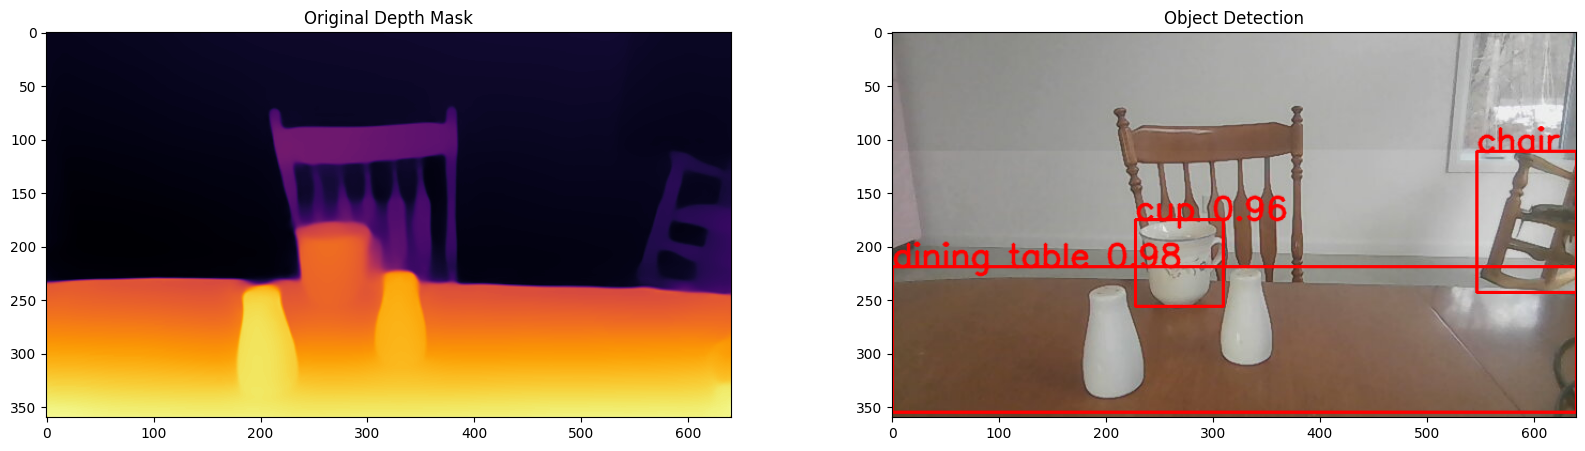

In [16]:
from transformers import pipeline, YolosConfig, YolosModel
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import ipywidgets as widgets
from tempfile import NamedTemporaryFile
from pathlib import Path

configuration = YolosConfig()
model = YolosModel(configuration)
configuration = model.config


image = cv2.cvtColor(cv2.imread("../assets/sel&poivre.jpg"), cv2.COLOR_BGR2RGB)
# Setup the pipeline
depth_estimator = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")
depth = np.array(depth_estimator(Image.fromarray(image))["depth"])

obj_detector = pipeline("object-detection", model="hustvl/yolos-tiny")
bounding_boxes = obj_detector(Image.fromarray(image))

for bounding_box in bounding_boxes:
    box = bounding_box["box"]
    label = bounding_box["label"]
    score = bounding_box["score"]
    # draw bounding box, label and score on image from opencv
    x1 = box["xmin"] 
    y1 = box["ymin"] 
    x2 = box["xmax"] 
    y2 = box["ymax"]
    image = cv2.rectangle(image, (x1,y1), (x2, y2), (255, 0, 0), 2)
    image = cv2.putText(image, f"{label} {score:.2f}", (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].imshow(depth, cmap='inferno')
axes[0].set_title('Original Depth Mask')
axes[1].imshow(image)
axes[1].set_title('Object Detection')
plt.show()

## YoloV8 + Depth pipeline


0: 384x640 1 cup, 2 chairs, 1 potted plant, 1 dining table, 42.4ms
Speed: 1.0ms preprocess, 42.4ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


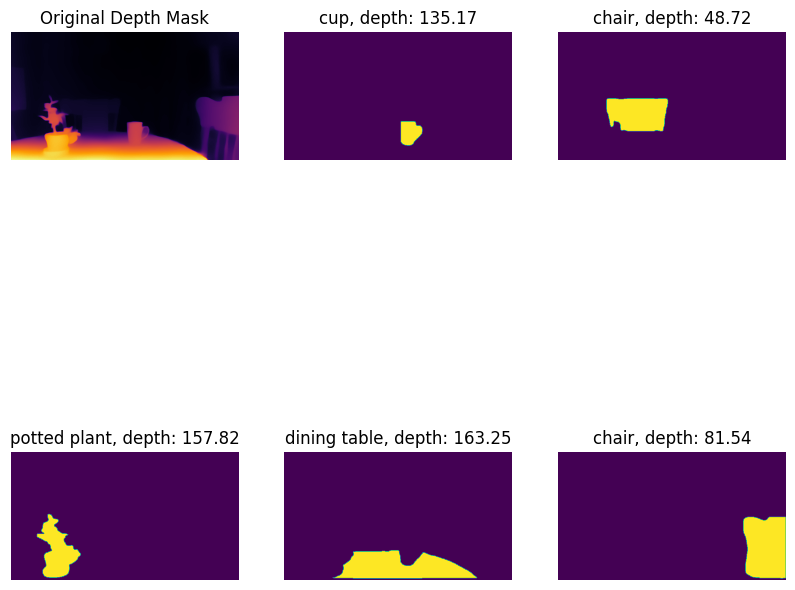

In [213]:
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt
import numpy as np
from transformers import pipeline
from PIL import Image

yolo_segmentation = YOLO('yolov8x-seg.pt')
img = cv2.cvtColor(cv2.imread("../assets/calib_1.jpg"), cv2.COLOR_BGR2RGB)


depth_estimator = pipeline(task="depth-estimation", model="LiheYoung/depth-anything-small-hf")
depth = np.array(depth_estimator(Image.fromarray(img))["depth"])


results = yolo_segmentation(source=img.copy())
for result in results:
    masks = result.masks
    resulting_masks = []
    classes = [result.names[id] for id in result.boxes.cls.tolist()]
    
    for c, mask_data in zip(classes, masks):
        mask = np.zeros(img.shape[:2], np.uint8)
        contour = mask_data.xy.pop().astype(np.int32)
        contour = contour.reshape(-1, 1, 2)

        _ = cv2.drawContours(mask, [contour], -1, (255,255,255), cv2.FILLED)
        resulting_masks.append((c, mask))

# Plot the resulting masks
num_masks = len(resulting_masks)
num_rows = (num_masks + 2) // 3  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, 3, figsize=(10, 10))

axes[0, 0].imshow(depth, cmap='inferno')
axes[0, 0].set_title('Original Depth Mask')
axes[0, 0].axis('off')

for i, (c, mask) in enumerate(resulting_masks):
    row = (i + 1) // 3
    col = (i + 1) % 3
    axes[row, col].imshow(mask, alpha=1)
    mean_depth = depth[mask > 0].mean()
    axes[row, col].set_title(f'{c}, depth: {mean_depth:.2f}')
    axes[row, col].axis('off')

# Remove empty subplots
for i in range(num_masks + 1, num_rows * 3):
    row = i // 3
    col = i % 3
    fig.delaxes(axes[row, col])

    

plt.show()